In [11]:
import emcee
import os
import rebound
import numpy as np
import astropy.constants as ast
import matplotlib.pyplot as plt
import pandas as pd

https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html

### Data Import

In [12]:
const ={
    'G' :  6.67430e10-11, #SI
    'R_b' : 0.0677, #AU
    'R_c' : 0.1189 , #AU
    'R_d' : 0.1662, #AU
    'R_e' : 0.2138, #AU
    'R_f' : 0.2535, #AU
    'P_b' : 5.7, # days
    'P_c' : 13.2, # days
    'P_d' : 21.8, # days
    'P_e' : 31.8, # days
    'P_f' : 41,# days
    'M_b' : 3.68, #Earth
    'M_c' : 0.39, #Earth
    'M_d': 3.91, #Earth
    'M_e' : 5.57, #Earth
    'M_f': 9.6, #Earth
    'AU' : 1.496e11, #m
    'M_star' : 1.29, # solar mass
    'M_sun' : 1.988e30, # kg
    'day_to_sec' : 86400,
    'M_earth' : 5972e24, #kg
    'M_earth_sun' : 3e-6 # solar masses
}

In [13]:
data1 = np.genfromtxt('koi707_timing/koi0707.01.tt')
data2 = np.genfromtxt('koi707_timing/koi0707.02.tt')
data3 = np.genfromtxt('koi707_timing/koi0707.03.tt')
data4 = np.genfromtxt('koi707_timing/koi0707.04.tt')
data5 = np.genfromtxt('koi707_timing/koi0707.05.tt')

data = [data1, data2, data3, data4, data5] # All data together
x = np.zeros_like(data1[:,0]) # Setting up dummy variable for later

y_array = [] 
y_err_array = []

for i in range(len(data)):
    
    inter = data[i]
    
    y_array.append(inter[:,0]+inter[:,1]) # Adding the first 2 columns of data
    y_err_array.append(inter[:,2]) # Creating uncertainty array

    
## Planet f (index 1) has the smallest initial time
final_y = []
for i in (y_array):
    final_y.append(i - y_array[1][0]) # Resetting time to get c at s t=0 starting time

In [14]:
def fCalc(b4T0, P, e):
    '''
    To approximate the starting positions. First, we find the mean ananomaly, taking T0 as periapsis.
    Then, we approximate the eccentric ananomaly as the mean ananomaly as e is small. We then directly
    derive our true ananomaly from our eccentric ananomaly, given as the alternate form from
    https://en.wikipedia.org/wiki/True_anomaly
    '''
    M = (P - b4T0)/P # mean ananomaly approximately eccentric ananomaly when e is small.
    # The calculation to derive the true 
    beta = e/(1+np.sqrt(1-e**2))
    temp = beta*np.sin(M)/(1-beta*np.cos(M))
    f = M + 2*np.arctan(temp)
    return f

    
# Handling our data which are the parameters for the simulation. 
exoNames = ['b', 'c', 'd', 'e', 'f']
df = pd.read_csv('kep33Data(Sheet1).csv', names=exoNames)

# Getting the required data for inputting into the parameters.
getData = lambda idx: np.array(df.iloc[idx], dtype=float)
eArr = getData(1)
fCol = fCalc(getData(4), getData(0), eArr) # true anomaly gives us our initial position but this must be calculated from our timings.


### Orbit functions

In [15]:
def transit(x, y, dt):
    ' Define the transit to be at y=0 in the axis on the right (x positive) '
    t_transit = []
    
    if len(np.where(y == 0)[0]) != 0: # Verifying if there is a y = 0 solution
        for i in range(len(y)):
            if np.abs(x[i]) == x[i]:  # Verifying if x is positive
                # Adding time by taking the index (number of iterations) * change in t
                t_transit.append(dt*i)
    else:
        index = np.where(np.diff(np.sign(y)))[0] # Getting array where y value changes sign
        for i in index:
            if np.abs(x[i]) == x[i]: # Verifying if x is positive
                #Taking proportion to interpolate time value at y=0
                diff = np.abs(y[i]-y[i+1])
                prop = np.abs(y[i])/diff
                new_dt = prop*dt
                t = dt*(i)+new_dt #Time at index and additional time
                t_transit.append(t)
                
    return t_transit

In [16]:
def orbit_setup(params):
    mass_earth = 3e-6 # Mass earth in solar masses
    
    kep33 = rebound.Simulation() # This sets up our system
    # kep33.integrator = 'whfast'
    # Our star is at the centre of the system with no velocity etc, so no orbital elements for it except mass.
    kep33.add(m=1.29) 
    # Populating the simulation with our planets right now. 
    for i, colName in enumerate(exoNames):
        if i == 4:
            kep33.add(m=params[0], P=getData(0)[i], e=params[2], f=params[1], inc=np.pi/2)
        else:
            kep33.add(m=(getData(3)* (ast.M_earth.value/ast.M_sun.value))[i], P=getData(0)[i], e=getData(1)[i], inc=np.pi/2, f=fCol[i])

    kep33.move_to_com() # Moving our system to the centre of mass frame, which should be in the star
            

    times = np.arange(0, 365, 0.01) # Randomly spaced observations for a year
    dt = np.mean(np.gradient(times)) # Time step
    N = len(times) # Number of iterations
    # Set up 0 arrays to update with x and y values
    p1,p2,p3,p4,p5 = np.zeros((N,2)), np.zeros((N,2)),np.zeros((N,2)),np.zeros((N,2)),np.zeros((N,2))

    for i, t in enumerate(times):
        kep33.integrate(times[i]) # Integrator
        # Uodating x and y values for each planet
        p1[i] = np.array([kep33.particles[1].x, kep33.particles[1].z])
        p2[i] = np.array([kep33.particles[2].x, kep33.particles[2].z])
        p3[i] = np.array([kep33.particles[3].x, kep33.particles[3].z])
        p4[i] = np.array([kep33.particles[4].x, kep33.particles[4].z])
        p5[i] = np.array([kep33.particles[5].x, kep33.particles[5].z])
        
#     Finding transits with our planet
#     t_transit_2 = transit(p2[:, 0], p2[:, 1], dt)
#     t_transit_1 = transit(p1[:, 0], p1[:, 1], dt)
#     t_transit_3 = transit(p3[:, 0], p3[:, 1], dt)
#     t_transit_4 = transit(p4[:, 0], p4[:, 1], dt)
    t_transit_5 = transit(p5[:, 0], p5[:, 1], dt)
    
    
    return t_transit_5 #np.array[t_transit_1, t_transit_2, t_transit_3, t_transit_4, t_transit_5]

### MCMC Functions

In [17]:
def model(theta, x=x):
    # Parameters
    M, f, e = theta
    params = np.array([M, f, e])
    model = orbit_setup(params) # Getting our model transit time
    return model

def lnlike(theta, x, y, yerr):
    ymodel = model(theta)
    
    # Getting the same number of transits 
    # Maybe append zeros intead??? -------------------------
    if len(ymodel)>len(y):
        ymodel = ymodel[0:len(y)]
        
    elif len(ymodel)<len(y):
        y = y[0:len(ymodel)]
        yerr = yerr[0:len(ymodel)]

    # Getting proportionality value
    LnLike = -0.5*np.sum(((y - ymodel)/yerr)**2)
    # Getting chi square value
    chi = np.sum((((y - ymodel))/yerr)**2)
    
    # Updating txt file
    file = open('chi_param_copy.txt', 'a')
    file.write(str(chi)+'\t'+str(theta)+'\n')
    file.close()
    
    return LnLike

# Setting up boundary conditions
def lnprior(theta):
    M, f, e = theta
    if 0.0 <= e < 1.0 and 0.0 < f < 2*np.pi and 0.0 < M < 11.9823029702415237e-05 :
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    # Calculating probability
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


In [18]:
#Resetting file
reset = open("chi_param_copy.txt",'w')
reset.close()


# Adding title
file =  open('chi_param_copy.txt', 'a')
file.write('chi\tparam\n')
file.close()

# Initial params
M = (getData(3)* (ast.M_earth.value/ast.M_sun.value))[4]+0.5e-6
f = fCol[4]+0.009
e = getData(1)[3]+0.01

p_initial = np.array([M, f, e])
ndim = len(p_initial)
nwalkers = 13
niter = 300
data = (x, final_y[1][1:], y_err_array[1][1:])
p0 = [np.array(p_initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]


In [19]:
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    # Updating txt file
    file = open('chi_param_copy.txt', 'a')
    file.write('0'+'\t'+'0'+'\n')
    file.close()
    

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [20]:
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data)

Running burn-in...


/Users/carolinedeland/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Running production...
emcee: Exception while calling your likelihood function:
  params: [4.44771712e-05 9.31332135e-01 1.63748179e-01]
  args: (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([  41.01753407,   82.04866269,  123.06386927,  164.11944179,
        205.13622899,  246.181123  ,  287.21967469,  328.20718133,
        369.22058778,  410.26940148,  451.2910436 ,  492.33067832,
        533.3750309 ,  574.4017803 ,  615.43764744,  656.45320255,
        697.47944088,  738.48035785,  779.52518137,  820.53967724,
        861.5884579 ,  902.61410124,  943.65661924,  984.69791936,
       1025.67544483, 1066.71904722, 1107.74692616, 1148.76802894,
       1189.80926344, 1230.839174  , 1271.87325349, 1312.87611591,
       1394.93993042, 1435.95051773])

Traceback (most recent call last):
  File "/Users/carolinedeland/opt/anaconda3/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/ff/_r7359n921zcpcgllv4znt_40000gn/T/ipykernel_28936/3773999862.py", line 44, in lnprob
    return lp + lnlike(theta, x, y, yerr)
  File "/var/folders/ff/_r7359n921zcpcgllv4znt_40000gn/T/ipykernel_28936/3773999862.py", line 9, in lnlike
    ymodel = model(theta)
  File "/var/folders/ff/_r7359n921zcpcgllv4znt_40000gn/T/ipykernel_28936/3773999862.py", line 5, in model
    model = orbit_setup(params) # Getting our model transit time
  File "/var/folders/ff/_r7359n921zcpcgllv4znt_40000gn/T/ipykernel_28936/2544986597.py", line 25, in orbit_setup
    kep33.integrate(times[i]) # Integrator
  File "/Users/carolinedeland/opt/anaconda3/lib/python3.9/site-packages/rebound/simulation.py", line 1397, in integrate
    raise KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: 

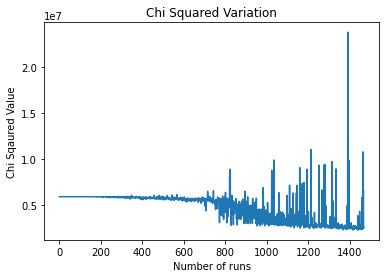

/Users/carolinedeland/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


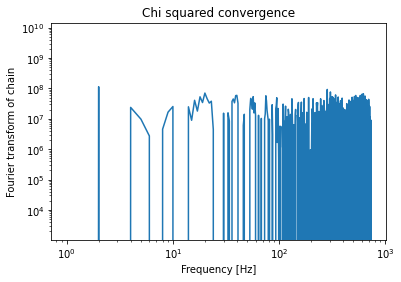

In [25]:
chi_data = np.genfromtxt('chi_param_copy.txt', delimiter='\t', skip_header=1)
chi = chi_data[:,0]

fft_chi = np.fft.rfft(chi)

plt.plot(chi)
plt.xlabel('Number of runs')
plt.ylabel('Chi Sqaured Value')
plt.title('Chi Squared Variation')
plt.show()

plt.plot(fft_chi)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Fourier transform of chain')
plt.title('Chi squared convergence')
plt.xscale('log')
plt.yscale('log')
plt.show()